In [1]:
import shap
import pandas as pd
import numpy as np
import psycopg2
from analysys_funcs import *
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import optuna
import math
from sklearn.preprocessing import RobustScaler, MinMaxScaler

c:\Users\eliza\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


"Сырые" данные о квартирах хранятся в базе данных. Для их получения необходимо установить соединение с ней.

In [19]:
conn = psycopg2.connect(host='ep-black-pond-a2ydwdvs.eu-central-1.aws.neon.tech', database='Akademdb', user='Elizar54', password='XUpC1QOnGvA4')
cur = conn.cursor()

Загружаем данные из базы данных.

In [20]:
df = pd.read_sql_query('select distinct * from flats_new', conn)

C:\Users\eliza\AppData\Local\Temp\ipykernel_14516\1139197693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query('select distinct * from flats_new', conn)


Осуществляем общую предобработку данных. В предварительную предобработку вошли следующие составляющие:
1. Приведение информации о расстоянии до метро, цене, площади квартиры, количестве туалетов, лифтов, балконах и лоджиях в корректный формат для дальнейшей работы;
2. Удаление колонок, состоящих по большей части из пропущенных значений (trash), не несущих какой-либо важной информации (id), содержащих большое количество пропущенных значений (decor, year) или одинаковые для всех наблюдений значения (rented).
3. Удаление дупликатов.
4. Заполнение пропусков. Пропуски в колонках с численными значениями были заполнены средним или средним по группе (расстояние до метро в минутах), для категориальных признаков использовалась мода.
5. Удаление наблюдений, в которых отсутствовала информация об общей жилой площади, жилой площади и площади кухни.
6. Удаление наблюдений с некорректным названием района.

In [21]:

df['metro'] = df['metro'].apply(metro_distance)
df['price'] = df['price'].apply(price_corr)
df.drop('trash', inplace=True, axis=1)
df.drop_duplicates(inplace=True)

for column in ['total_square', 'living_sq', 'kitchen_sq']:
    df[column] = df[column].apply(square_corr)

df['floor'] = df['floor'].apply(floor_corr)
df['ceil_height'] = df['ceil_height'].apply(lambda x: float(x.replace(',', '.').split()[0]) if x != 'None' else np.nan)
df['entrance'] = df['entrance'].apply(lambda x: int(x) if x != 'None' else np.nan)
df['barriers'] = df['barriers'].apply(lambda x: x if x != 'Нет информации' else df['barriers'].mode()[0])
df['district'] = df['address'].apply(lambda x: x.split()[4] if len(x) >=4 else x)

df = df.replace('None', np.nan)

df.drop('address', inplace=True, axis=1)



<Axes: xlabel='Название колонки', ylabel='Доля пропущенных значений в столбце'>

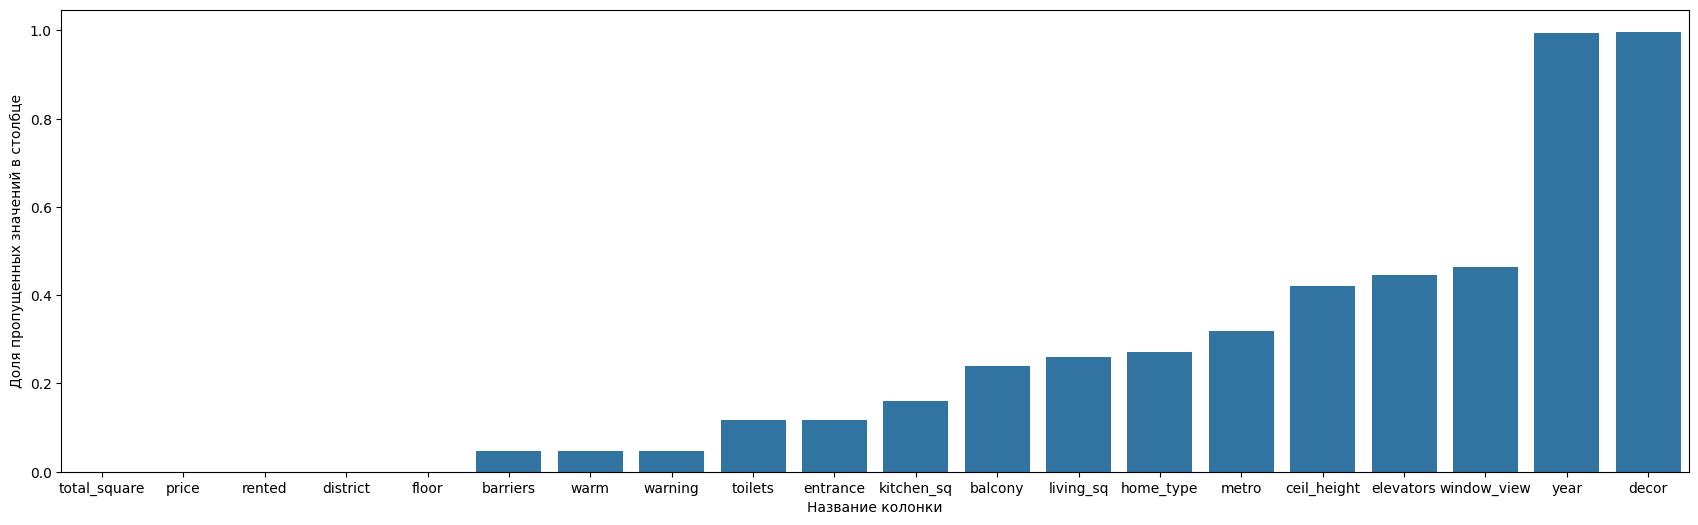

In [5]:
plt.figure(figsize=(21, 6))
plt.xlabel('Название колонки')
plt.ylabel('Доля пропущенных значений в столбце')
sns.barplot(df.isna().sum().sort_values()/len(df))

In [22]:
df['barriers'].fillna(df['barriers'].mode()[0], inplace=True)
df['toilets'].fillna(df['toilets'].mode()[0], inplace=True)
df['warm'].fillna(df['warm'].mode()[0], inplace=True)
df['warning'].fillna(df['warning'].mode()[0], inplace=True)
df['home_type'].fillna(df['home_type'].mode()[0], inplace=True)
df['ceil_height'] = df['ceil_height'].apply(lambda x: x/10 if x > 10 else x)
df['big_elevs'] = df['elevators'].apply(big_elevators)
df['little_elevs'] = df['elevators'].apply(lit_elevators)
df['single_toilet'] = df['toilets'].apply(toilet_single)
df['connect_toilet'] = df['toilets'].apply(toilet_not_sngl)
df['balconies'] = df['balcony'].apply(balcony)
df['lodgia'] = df['balcony'].apply(lodgia)

df = df[df['district'].isin(['Советский', 'Центральный', 'Октябрьский', 'Кировский', \
                              'Ленинский', 'Заельцовский', 'Железнодорожный', 'Первомайский', 'Дзержинский', 'Калининский'])]

In [23]:
df.drop(['decor', 'year', 'balcony', 'elevators', 'toilets'], axis=1, inplace=True)

df['ceil_height'].fillna(df['ceil_height'].mode()[0], inplace=True)

df['ceil_height'] = df['ceil_height'].apply(lambda x: x if x != 0 else 2.7)

df['warm'] = df['warm'].apply(lambda x: 'Центральное' if x == 'Нет информации' else x)
df['window_view'].fillna(df['window_view'].mode()[0], inplace=True)
df = df.dropna(subset=['kitchen_sq', 'total_square', 'living_sq'])
cat_features = ['home_type', 'warm', 'district', 'window_view', 'barriers', 'rented', 'warning']

df['single_toilet'] = df['single_toilet'].apply(lambda x: x if x != 'None' else 0)
df['connect_toilet'] = df['connect_toilet'].apply(lambda x: x if x != 'None' else 0)

df['metro'].fillna(round(df.groupby('district')['metro'].transform('mean')), inplace=True)

df['entrance'].fillna(round(df['entrance'].mode()[0]), inplace=True)

Так как такие модели как линейная регрессия и случайный лес не могут работать с категориальными признаками, необходимо сформировать датафррейм, в котором категориальные переменные будут преобразованы в dummy переменные. По сути, это то же самое, что и кодирование с помощью One-Hot Encoder. Укажем, что drop_first = True во избежание возникновения мультиколлинеарности.

In [24]:
df_dummy = pd.get_dummies(df, columns=cat_features, dtype = 'float64', drop_first=True)

Проведем EDA (exploratory data analysis). Для начала, построим точечные графики, которые помогут нам пронаблюдать зависимость цены квартир от различных значимых, на мой взгляд, параметров. В качестве таких параметров я выбрал общую площадь, жилую площадь, площадь кухни и высоту потолков. Можем видеть, что присутствует сильная положительная корреляция между площадью и ценой на квартиру. Корреляция между высотой потолков и ценой квартиры очень мала, на первый взгляд. Заметны сильные выбросы в данных. Ими нужно будет заняться.

<Axes: xlabel='Высота потолков', ylabel='Цена квартиры'>

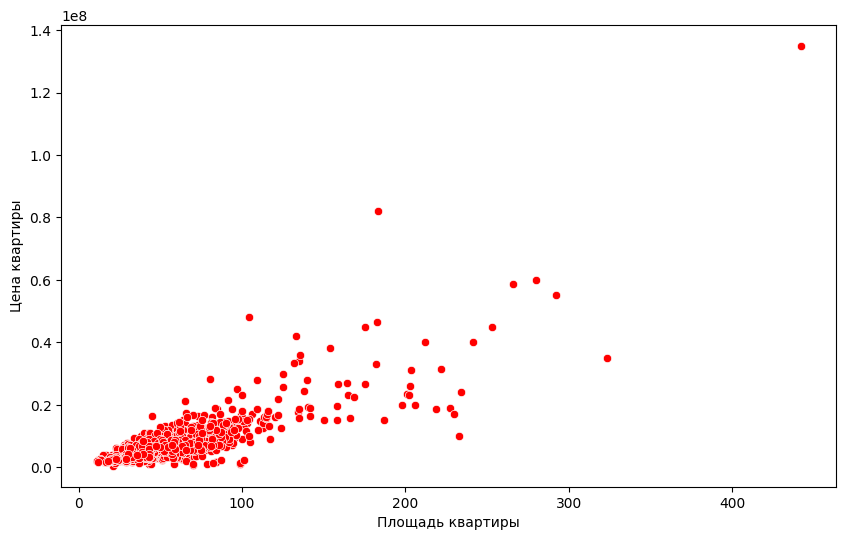

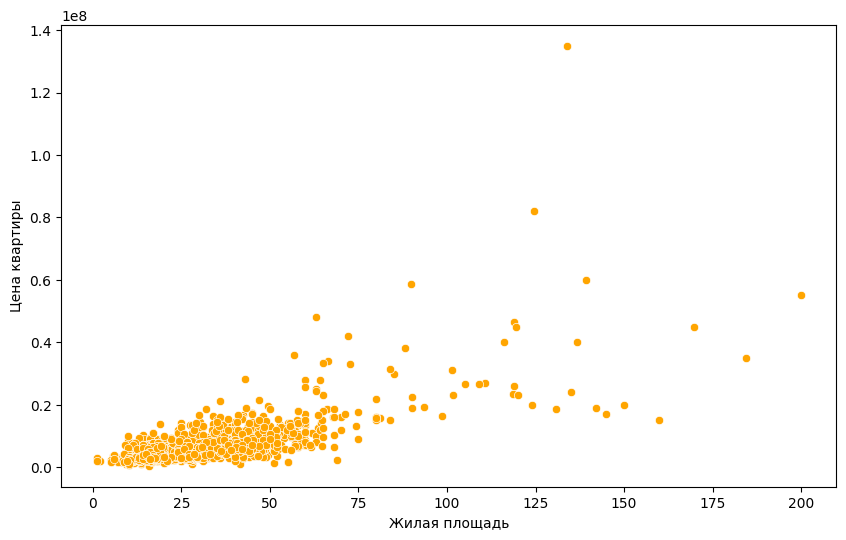

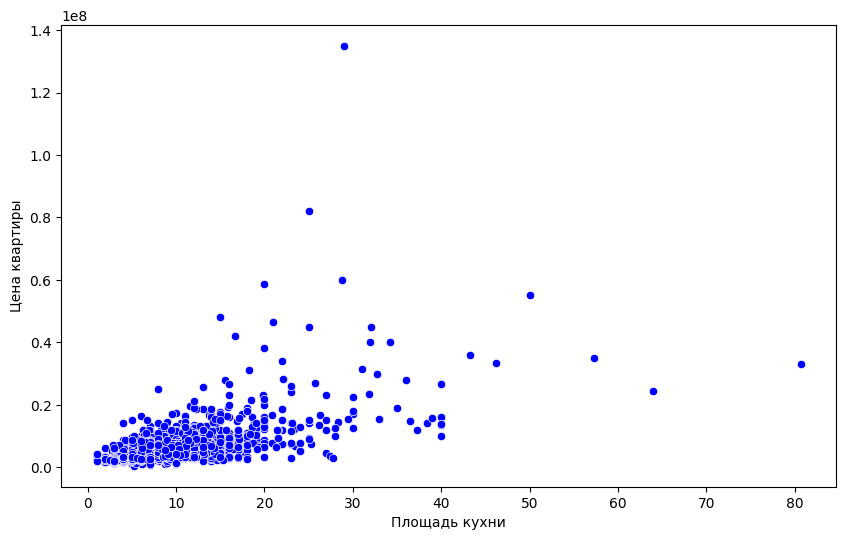

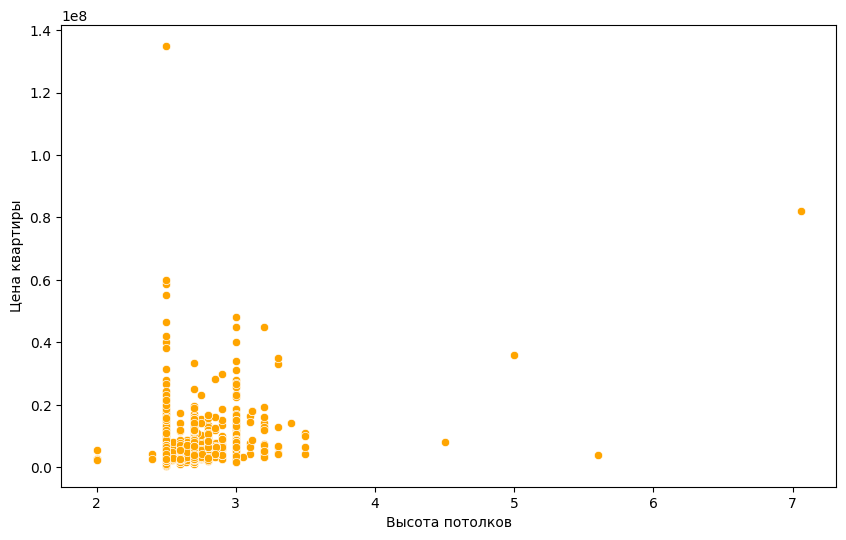

In [47]:
plt.figure(figsize=(10, 6))

plt.xlabel('Площадь квартиры')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['total_square'], y=df_dummy['price'], color='red')

plt.figure(figsize=(10, 6))
plt.xlabel('Жилая площадь')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['living_sq'], y=df_dummy['price'], color='orange')

plt.figure(figsize=(10, 6))
plt.xlabel('Площадь кухни')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['kitchen_sq'], y=df_dummy['price'], color='blue')

plt.figure(figsize=(10, 6))

plt.xlabel('Высота потолков')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df['ceil_height'], y=df['price'], color='orange')

Теперь взглянем на распределение цен квартир. Для иллюстрации распределения я использовал гистограмму, добавил ядерную оценку плотности. В результате мы можем видеть тяжелый правый хвост и ассимметрию.

<Axes: title={'center': 'Гистограмма цен на квартиры'}, xlabel='Цена квартиры', ylabel='Количество квартир'>

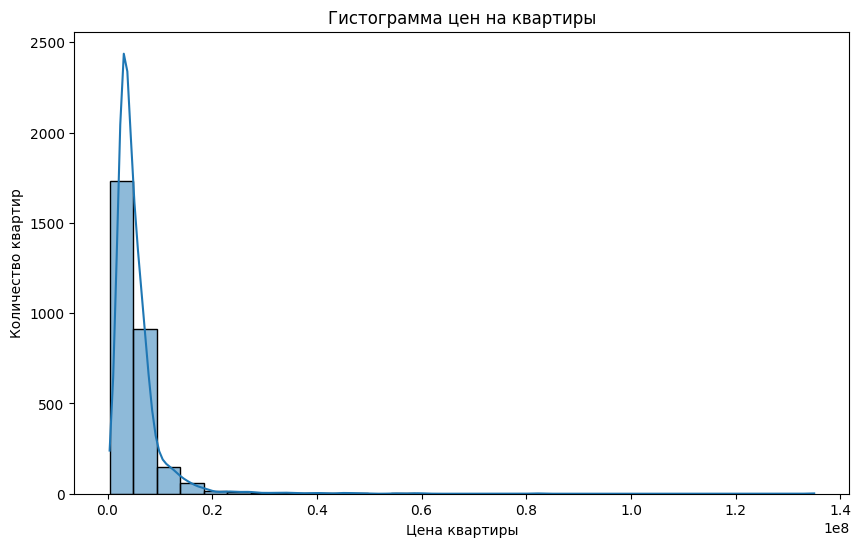

In [68]:
plt.figure(figsize=(10, 6))
plt.xlabel('Цена квартиры')
plt.ylabel('Количество квартир')
plt.title('Гистограмма цен на квартиры')
sns.histplot(df['price'], bins=30, kde=True)

Посмотрим на распределение логарифма цен на квартиры. Оно уже больше напоминает нормальное.

<Axes: title={'center': 'Гистограмма логарифмированных цен на квартиры'}, xlabel='Логарифм цены квартиры', ylabel='Количество квартир'>

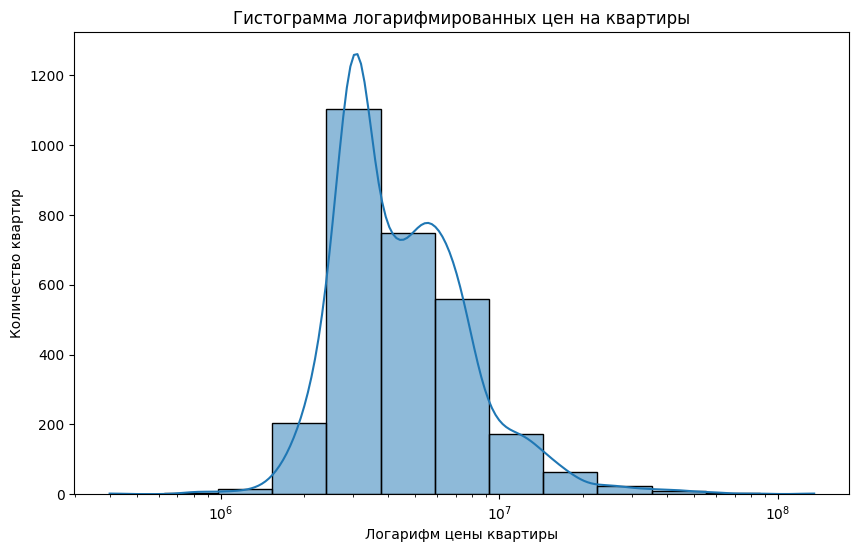

In [69]:
plt.figure(figsize=(10, 6))
plt.xlabel('Логарифм цены квартиры')
plt.ylabel('Количество квартир')
plt.title('Гистограмма логарифмированных цен на квартиры')
sns.histplot(df['price'], bins=(round(1 + 3.322*math.log(len(df), 10))), log_scale=True, kde=True)

Теперь посмотрим на гистограмму площадей квартир. Виден тяжелый правый хвост и ассимметрия. Однако уже можно сказать, что у большей части квартир площадь не превышает 100 квадратных метров.

<Axes: title={'center': 'Гистограмма общей площади квартир'}, xlabel='Общая площадь квартиры', ylabel='Количество квартир'>

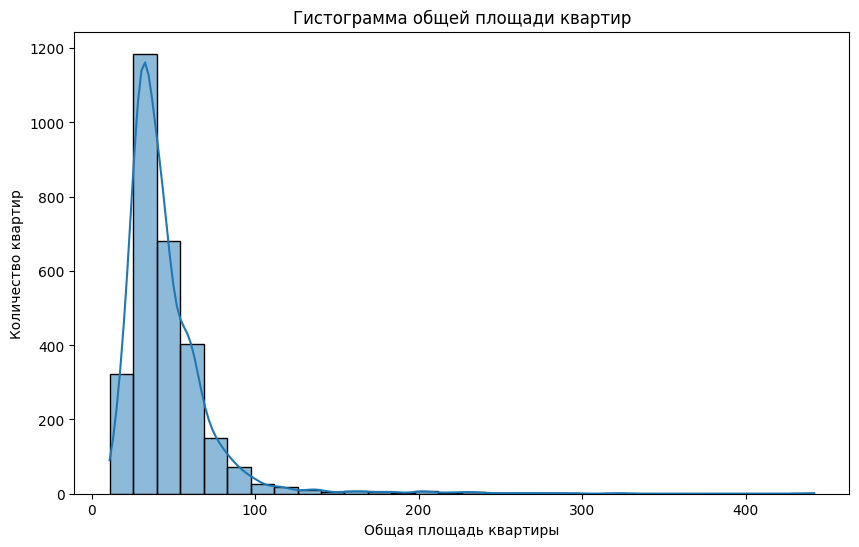

In [70]:
plt.figure(figsize=(10, 6))
plt.title('Гистограмма общей площади квартир')
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Количество квартир')
sns.histplot(df_dummy['total_square'], bins=30, kde=True)

Взглянем на то, как распределено расстояние от квартир до метро в минутах. Большая часть квартир находится примерно в 15 минутах от метро.

<Axes: xlabel='Расстояние до метро (в минутах)', ylabel='Количество квартир'>

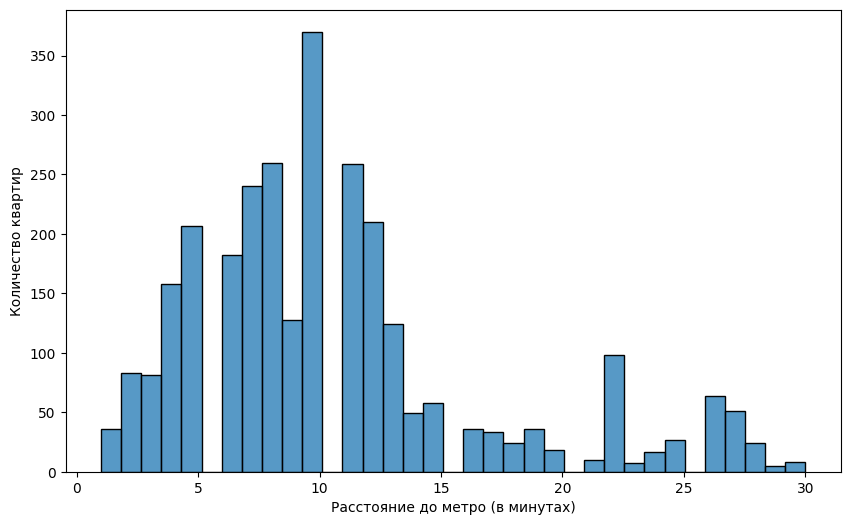

In [71]:
plt.figure(figsize=(10, 6))
plt.xlabel('Расстояние до метро (в минутах)')
plt.ylabel('Количество квартир')
sns.histplot(df['metro'])

In [346]:
df['metro'].describe()

count    2553.000000
mean       10.785742
std         6.176791
min         1.000000
25%         7.000000
50%        10.000000
75%        12.000000
max        30.000000
Name: metro, dtype: float64

Посмотрим на общее соотношение районов в датафрейме. Как можно видеть, меньше всего квартир из Советского района, больше всего - из Ленинского и Кировского.

<Axes: xlabel='Район', ylabel='Количестов квартир'>

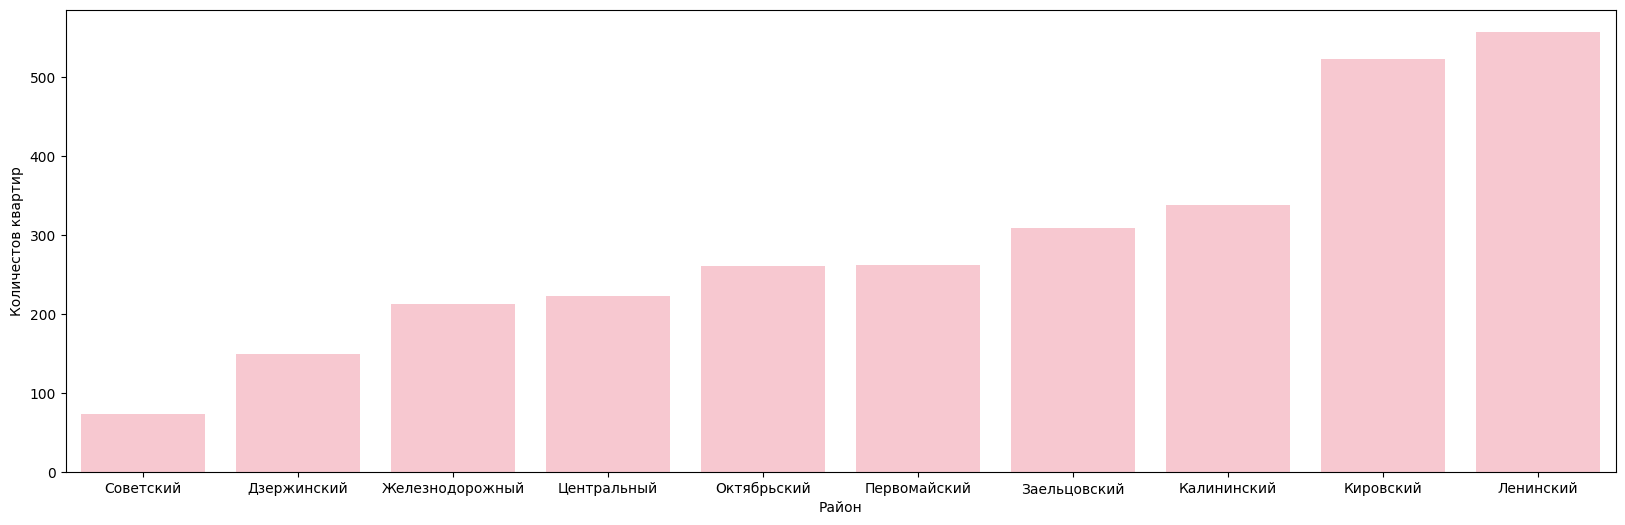

In [72]:
plt.figure(figsize=(20, 6))
plt.ylabel('Количестов квартир')
plt.xlabel('Район')
districts = df['district'].value_counts(ascending=True)
sns.barplot(districts, color='pink')

Пора разобраться с выбросами. Удалять выбросы будем с помощью межквартирльного размаха (IQR). 

In [25]:

for column in['total_square', 'ceil_height', 'kitchen_sq']:
    q1 = df_dummy[column].quantile(0.25)
    q3 = df_dummy[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    df_dummy = df_dummy[df_dummy[column].between(lower_bound, upper_bound)]
    df = df[df[column].between(lower_bound, upper_bound)]
    

Посмотрим на то, как изменилась гистограмма площади квартир. Видно, что правый хвост стал менее тяжелым, нам удалось избавиться от самых явных выбросов.

<Axes: title={'center': 'Гистограмма общей площади квартир'}, xlabel='Общая площадь квартиры', ylabel='Количество квартир'>

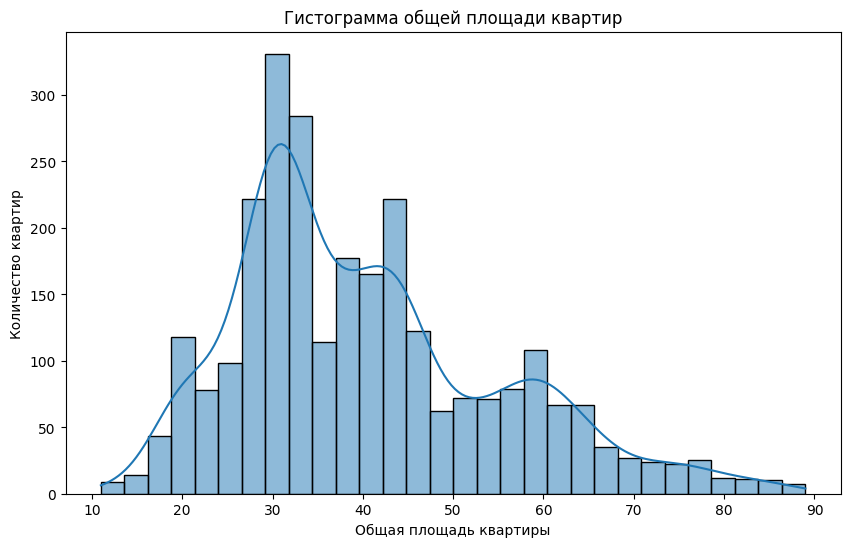

In [10]:
plt.figure(figsize=(10, 6))
plt.title('Гистограмма общей площади квартир')
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Количество квартир')
sns.histplot(df_dummy['total_square'], bins=30, kde=True)

После удаления выбросов также будет полезно взглянуть на то, как изменился точечный график цены квартиры и ее общей площади, площади кухни, жилой площади. К тому же, я решил посмотреть, на то, как зависит цена квартиры от типа дома и расстояния до метро. Сделал это также с помощью точечных графиков. График с типом дома и его ценой оказался не особо информативным. График с метро показал, что все-таки квартиры, расположенные рядом с метро, наверное, стоят в среднем больше чем те, что находятся далеко от метро. Конечно, сказать что-то конкретное можно только после проведения статистических тестов.

<Axes: xlabel='Расстояние до метро (в минутах)', ylabel='Цена квартиры'>

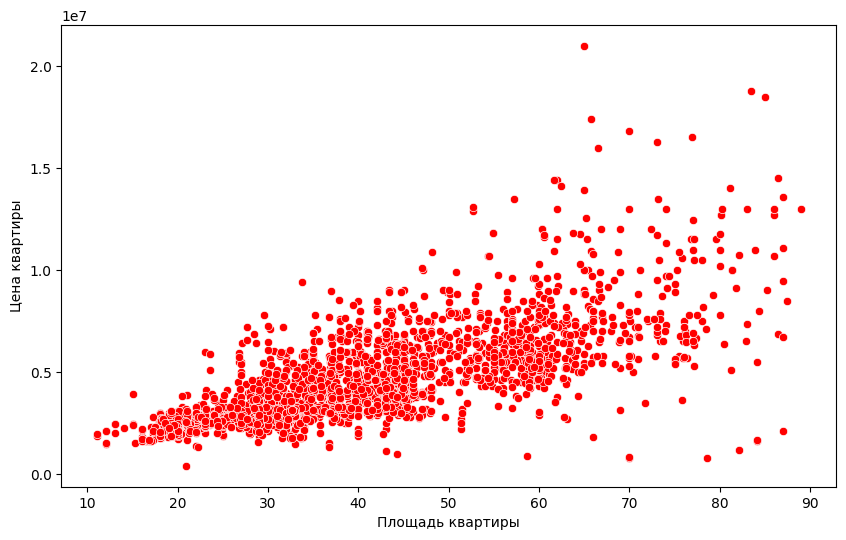

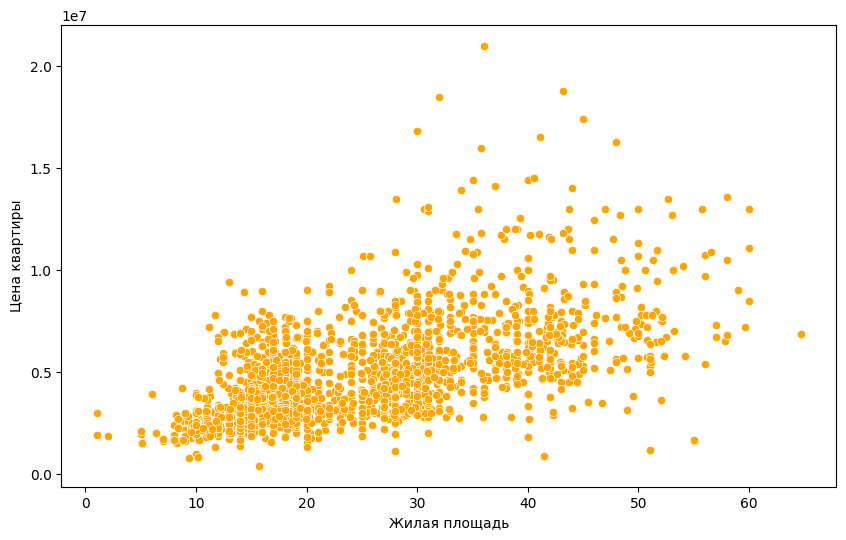

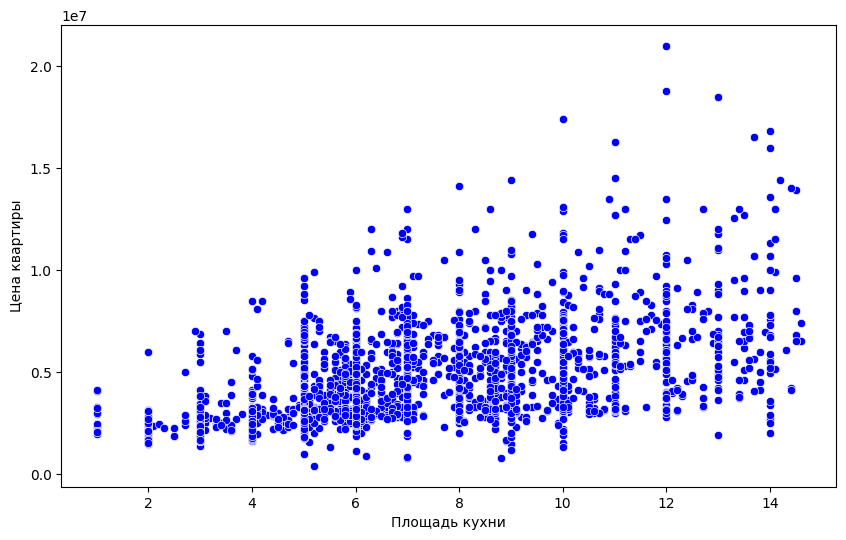

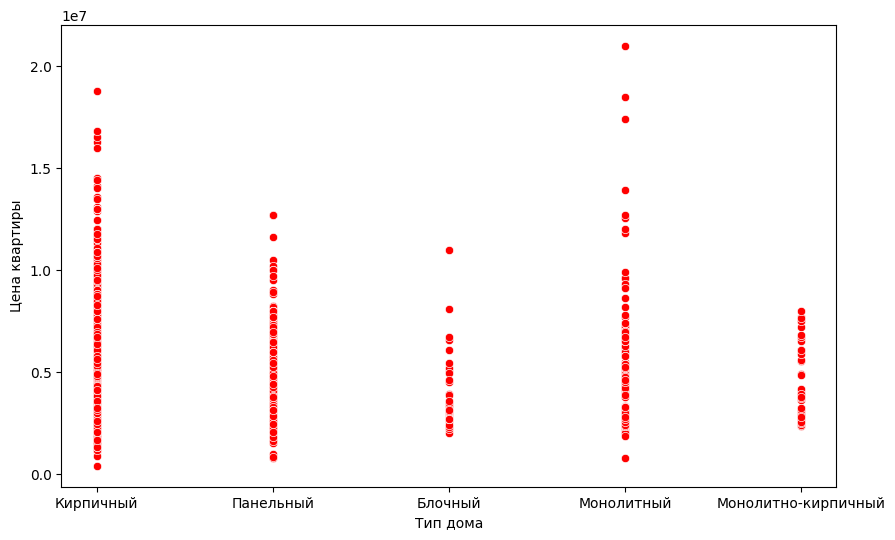

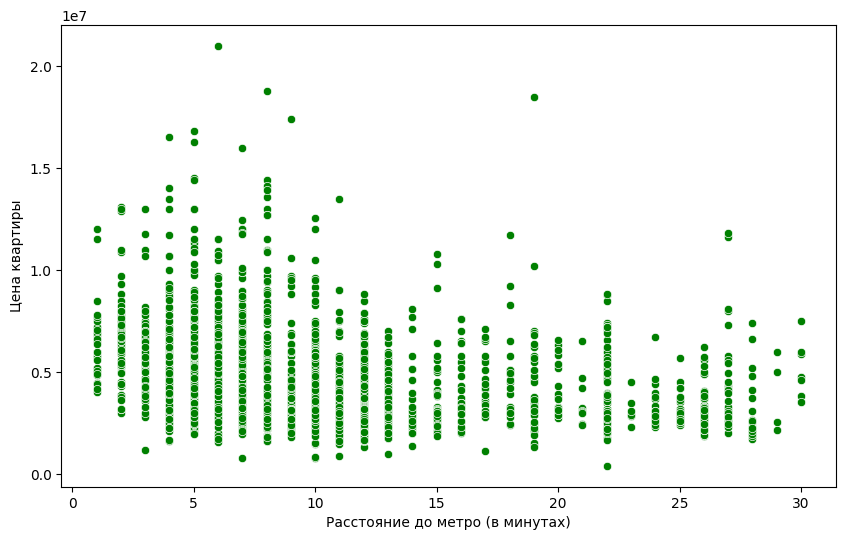

In [26]:
plt.figure(figsize=(10, 6))

plt.xlabel('Площадь квартиры')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['total_square'], y=df_dummy['price'], color='red')

plt.figure(figsize=(10, 6))
plt.xlabel('Жилая площадь')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['living_sq'], y=df_dummy['price'], color='orange')

plt.figure(figsize=(10, 6))
plt.xlabel('Площадь кухни')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['kitchen_sq'], y=df_dummy['price'], color='blue')

plt.figure(figsize=(10, 6))
plt.xlabel('Тип дома')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df['home_type'], y=df['price'], color='red')

plt.figure(figsize=(10, 6))
plt.xlabel('Расстояние до метро (в минутах)')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df['metro'], y=df['price'], color='green')

Теперь все-таки посмотрим на корреляционную матрицу числовых признаков. Можем видеть, что цена больше всего коррелирует с общей площадью, жилой площадью и площадью кухни.

<Axes: title={'center': 'Корреляционная матрица числовых признаков'}>

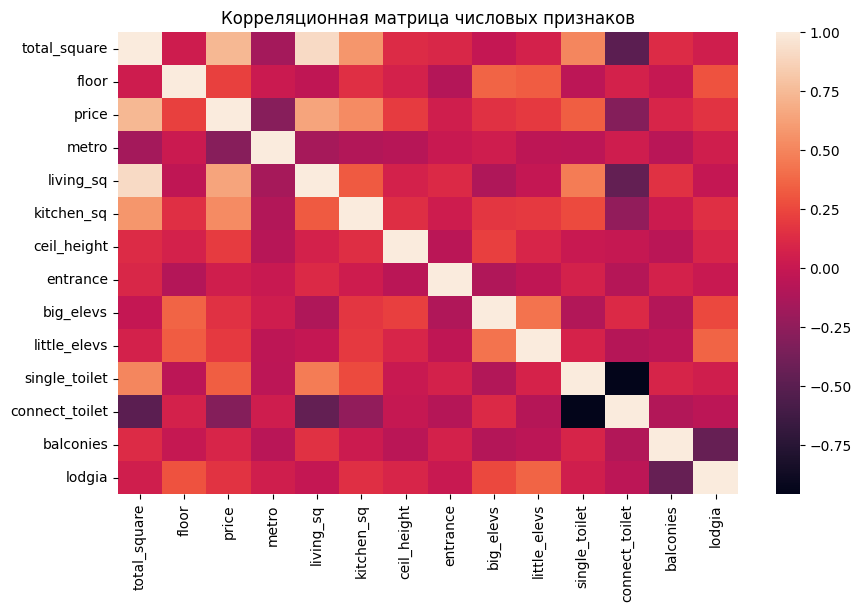

In [27]:
df_numeric = df.select_dtypes(['float64', 'int64'])
plt.figure(figsize=(10, 6))
plt.title('Корреляционная матрица числовых признаков')
sns.heatmap(df_numeric.corr())

Приступим к построению разлчиных моделей и сравнению их эффективности. Для начала разделим выборку на тренировочную и валидационную части. В силу небольшого объема данных, я не стал разделять выборку на тренировочную, тестовую и валидационную части. 

In [48]:
scaler = MinMaxScaler()
columns = df_dummy.columns.to_list()
df_dummy_lr = pd.DataFrame(scaler.fit_transform(df_dummy))
df_dummy_lr.index = df_dummy.index

for column in df_dummy_lr.columns:
    df_dummy_lr[columns[column]] = df_dummy_lr[column]
    df_dummy_lr.drop(column, axis=1, inplace=True)

In [28]:
train_lr, test_lr = train_test_split(df_dummy, test_size=0.2, random_state=34)

Построим линейную регрессию методом наименьших квадратов. На каждой итерации будем удалять незначимый регрессор.

In [29]:
maxpvalue = 1
n = 1
regressors = train_lr.drop('price', axis=1).columns.to_list()

while maxpvalue > 0.05:
    x = train_lr[regressors]
    y = train_lr['price']
    x1 = sm.add_constant(x)
    model = sm.OLS(y, x1.astype(float)).fit()
    pv = model.pvalues.to_list()
    maxpv = max(pv[1:])
    max_index = pv.index(maxpv)
    print('Номер интерации: '+ str(n))
    print('Регрессор с максимальным p-value: '+ str(regressors[max_index-1]) + ' P-value: '+ str(maxpv))
    print('-------------------------------------------------------------')

    if maxpv > 0.05:
        regressors.pop(max_index - 1)
        maxpvalue = maxpv
        n += 1
    else:
        maxpvalue = 0


Номер интерации: 1
Регрессор с максимальным p-value: window_view_На улицу и двор P-value: 0.9123596084696937
-------------------------------------------------------------
Номер интерации: 2
Регрессор с максимальным p-value: district_Советский P-value: 0.8269735109728109
-------------------------------------------------------------
Номер интерации: 3
Регрессор с максимальным p-value: barriers_Смешанные P-value: 0.770972633912592
-------------------------------------------------------------
Номер интерации: 4
Регрессор с максимальным p-value: rented_Вторичка Пентхаус P-value: 0.8309886691054673
-------------------------------------------------------------
Номер интерации: 5
Регрессор с максимальным p-value: rented_Вторичка Апартаменты P-value: 0.4843967877389881
-------------------------------------------------------------
Номер интерации: 6
Регрессор с максимальным p-value: entrance P-value: 0.40937084527122924
-------------------------------------------------------------
Номер интераци

Получили модель линейной регрессии. То, как влияет каждый регрессор на стоимость квартиры можно понять, исходя из коэффициента, стоящего перед этим регрессором.

In [30]:
print(model.summary2())

                                    Results: Ordinary least squares
Model:                          OLS                          Adj. R-squared:                 0.736     
Dependent Variable:             price                        AIC:                            64140.7290
Date:                           2024-05-19 20:59             BIC:                            64276.1035
No. Observations:               2081                         Log-Likelihood:                 -32046.   
Df Model:                       23                           F-statistic:                    253.7     
Df Residuals:                   2057                         Prob (F-statistic):             0.00      
R-squared:                      0.739                        Scale:                          1.4073e+12
-------------------------------------------------------------------------------------------------------
                                       Coef.       Std.Err.     t    P>|t|      [0.025        0.975]

Провалидируем нашу модель на тестовом наборе данных.

In [31]:
test_1 = test_lr[model.params.index.to_list()[1:]]
test_1 = sm.add_constant(test_1)
pred = model.predict(test_1)

Можем видеть, что средняя абсолютная ошибка равна 754 тысяч рублей, то есть в среднем модель ошибается на 778 тысяч в определении стоимости квартиры. Учитывая небольшой набор данных, это неплохой показатель, однако все-таки в будущем стоит провалидировать модель на данных, относящихся к разным ценовым категориям.

In [32]:
mean_absolute_error(test_lr['price'], pred)

756548.5679482839

Приступим к построению следующей модели - случайного леса (Random forest). Эта модель имеет множество гиперпараметров. Одни из самых важных - количество деревьев в ансамбле (n_estimators), минимальное количество наблюдений в узле дерева для перехода к следующему разделению данных (min_samples_split), максимальная глубина каждого дерева (max_depth). Подбор гиперпараметров осуществим с помощью такого алгоритма как TPESampler (Tree-structured Parzen Estimator). Функция потерь для минимизации - MSE.

In [33]:
df_dummy = pd.get_dummies(df, columns=cat_features, dtype = 'float64')

train, test = train_test_split(df_dummy, test_size=0.2, random_state=42)

def objective_rf(trial):
    X_train, X_val, y_train, y_val = train_test_split(df_dummy.drop(['price'], axis=1), df_dummy['price'], test_size=0.2, random_state=42)

    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    max_depth = trial.suggest_int('max_depth', 5, 10)

    model = RandomForestRegressor(max_depth=max_depth, max_features='sqrt', min_samples_split=min_samples_split, \
                                   n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    mse = mean_squared_error(y_val, val_preds)

    return mse

In [34]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective_rf, n_trials=200)

[I 2024-05-19 20:59:59,733] A new study created in memory with name: no-name-b0c1c6af-679c-473d-9405-9d3fe04bdf81
[I 2024-05-19 20:59:59,971] Trial 0 finished with value: 1444132731684.774 and parameters: {'n_estimators': 48, 'min_samples_split': 5, 'max_depth': 10}. Best is trial 0 with value: 1444132731684.774.
[I 2024-05-19 21:00:00,136] Trial 1 finished with value: 2030436307333.2424 and parameters: {'n_estimators': 68, 'min_samples_split': 5, 'max_depth': 5}. Best is trial 0 with value: 1444132731684.774.
[I 2024-05-19 21:00:00,175] Trial 2 finished with value: 1673551562562.588 and parameters: {'n_estimators': 11, 'min_samples_split': 5, 'max_depth': 8}. Best is trial 0 with value: 1444132731684.774.
[I 2024-05-19 21:00:00,286] Trial 3 finished with value: 1818847958326.735 and parameters: {'n_estimators': 44, 'min_samples_split': 4, 'max_depth': 6}. Best is trial 0 with value: 1444132731684.774.
[I 2024-05-19 21:00:00,331] Trial 4 finished with value: 1714040338151.023 and param

In [35]:
best_params = study.best_params
best_params

{'n_estimators': 46, 'min_samples_split': 6, 'max_depth': 10}

Подобрав гиперпараметры, обучим модель и провалидируем её. Можем видеть, что ошибка на тестовых данных ниже чем, у линейной регрессии. Однако, говорить об эффективности модели рановато. Проведем перекрестную оценку модели. 

In [36]:
model_rf = RandomForestRegressor(**best_params, max_features='sqrt', random_state=30)
model_rf.fit(train.drop('price', axis=1), train['price'])
pred_rf = model_rf.predict(test.drop('price', axis=1))

mean_absolute_error(pred_rf, test['price'])

713771.3302831849

In [37]:
explainer_rf = shap.Explainer(model_rf.predict, test.drop('price', axis=1))
shap_values_rf = explainer_rf(test.drop('price', axis=1))

PermutationExplainer explainer: 522it [00:56,  8.11it/s]                         


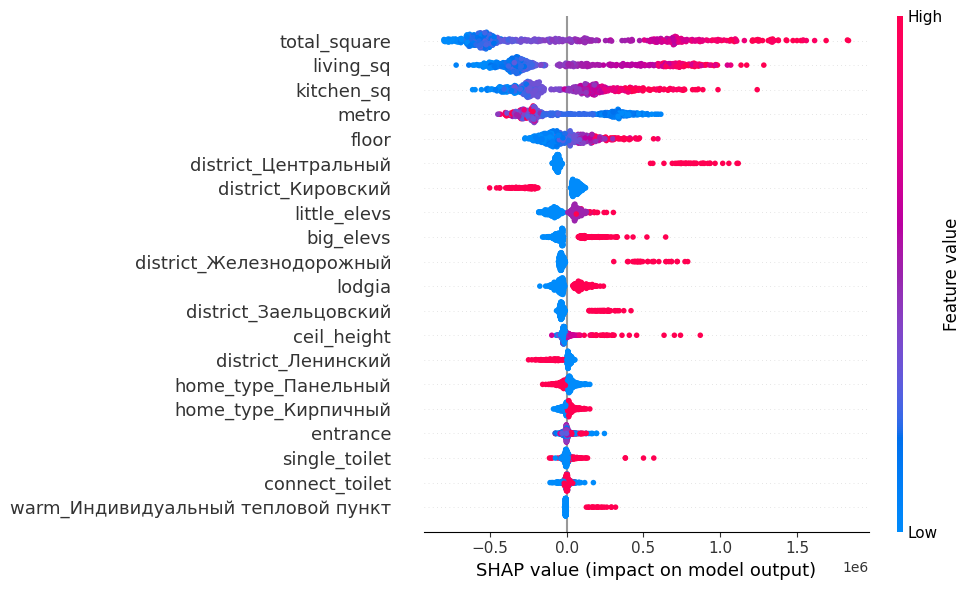

In [38]:
shap.summary_plot(shap_values_rf, plot_size=(10, 6))

Можем видеть, что порой абсолютная средняя ошибка оказывается довольно высокой (более 900 тысяч). Однако среднее значение ошибки по итогам кроссвалидации составило 732 тысячи.

In [117]:
cross_val_score(model_rf, df_dummy.drop('price', axis=1), df_dummy['price'], cv=5, scoring='neg_mean_absolute_error')

array([-700482.02981361, -751873.71783152, -699481.3105695 ,
       -660264.76303578, -681090.46417873])

In [118]:
cross_val_score(model_rf, df_dummy.drop('price', axis=1), df_dummy['price'], cv=5, scoring='neg_mean_absolute_error').mean()

-698638.457085828

In [35]:
df_compare_rf = pd.DataFrame({'real': test['price'], 'predicted': pred_rf})

Построим модель градиентного бустинга с использованием инструментария библиотеки catboost. Также осуществим подбор гиперпараметров с помощью TPESampler. Среди подбираемых параметров я перебрал количество деревьев в ансамбле (n_estimators), темп обучения (learning_rate), глубину каждого дерева (depth), а также коэффициент L2 регуляризации. В качестве функции потерь для минимизации выбрал MSE.

In [10]:
def objective_gb(trial):
    X_train, X_val, y_train, y_val = train_test_split(df.drop(['price'], axis=1), df_dummy['price'], test_size=0.2, random_state=42)

    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1)
    depth = trial.suggest_int('depth', 5, 10)
    l2_reg = trial.suggest_float('l2_leaf_reg', 0, 20)

    model = CatBoostRegressor(depth=depth, learning_rate=learning_rate, n_estimators=n_estimators, l2_leaf_reg=l2_reg, cat_features=cat_features)
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    mse = mean_squared_error(y_val, val_preds)

    return mse

In [ ]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective_gb, n_trials=100)

In [12]:
best_params = study.best_params
best_params

{'n_estimators': 100,
 'learning_rate': 0.3939093078732177,
 'depth': 7,
 'l2_leaf_reg': 18.138345500416737}

In [15]:
model_gb = CatBoostRegressor(**best_params, random_seed=42)
model_gb.fit(train.drop('price', axis=1), train['price'])

0:	learn: 1910567.1598008	total: 8.48ms	remaining: 839ms
1:	learn: 1643671.4146075	total: 11ms	remaining: 541ms
2:	learn: 1482251.9670613	total: 12.6ms	remaining: 409ms
3:	learn: 1387527.1128374	total: 14.8ms	remaining: 354ms
4:	learn: 1294677.4179527	total: 17.5ms	remaining: 333ms
5:	learn: 1238100.0485904	total: 19.8ms	remaining: 311ms
6:	learn: 1203512.7732393	total: 22.3ms	remaining: 296ms
7:	learn: 1174051.4602298	total: 24.9ms	remaining: 286ms
8:	learn: 1149348.3190858	total: 27.5ms	remaining: 278ms
9:	learn: 1129794.8460273	total: 30.1ms	remaining: 271ms
10:	learn: 1112146.1345085	total: 33.4ms	remaining: 270ms
11:	learn: 1086492.3423863	total: 36ms	remaining: 264ms
12:	learn: 1073321.5857405	total: 38.2ms	remaining: 256ms
13:	learn: 1061105.5752674	total: 39.1ms	remaining: 240ms
14:	learn: 1049925.2564643	total: 41.1ms	remaining: 233ms
15:	learn: 1035463.5048271	total: 43.4ms	remaining: 228ms
16:	learn: 1025050.2457659	total: 45.7ms	remaining: 223ms
17:	learn: 1010675.4348033	t

In [16]:
pred_gb = model_gb.predict(test.drop('price', axis=1))

In [17]:
explainer_gb = shap.Explainer(model_gb.predict, test.drop('price', axis=1))
shap_values_gb = explainer_gb(test.drop('price', axis=1))

PermutationExplainer explainer: 522it [00:25, 14.11it/s]                         


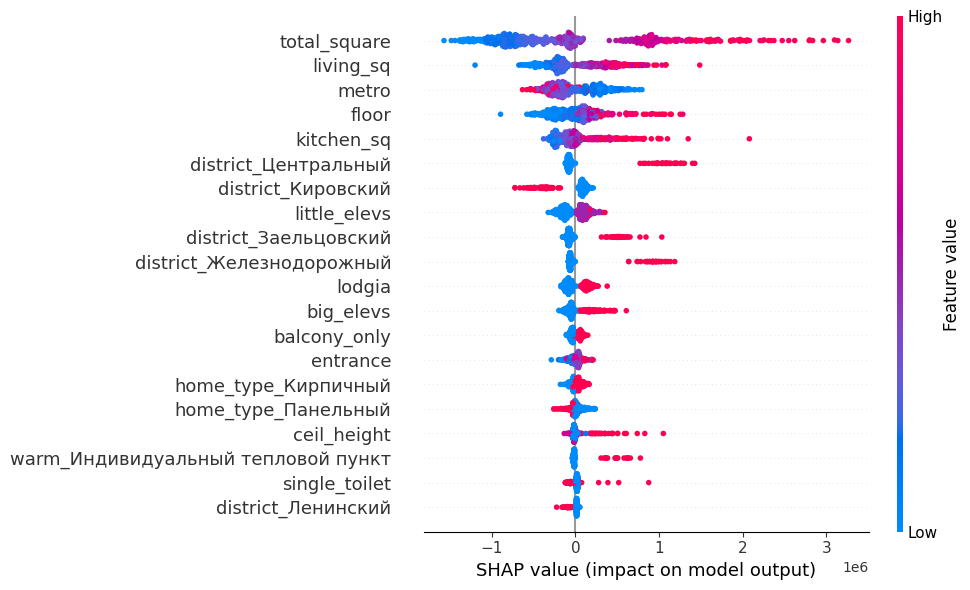

In [22]:
shap.summary_plot(shap_values_gb, plot_size=(10, 6))

Провалидируем модель. Как можем видеть, на тестовом наборе данных ошибка снизилась до 600 тысяч. Также проведем перекрестную оценку.

In [31]:
mean_absolute_error(test['price'], pred_gb)

658906.1124422299

In [55]:
compare_df_gb = pd.DataFrame({'real': test['price'], 'predicted': pred_gb})

Перекрестная оценка показала, что средняя ошибка стала еще ниже по сравнению со случайным лесом. 

In [32]:
cross_val_score(model_gb, df_dummy.drop('price', axis=1), df_dummy['price'], cv=5, scoring='neg_mean_absolute_error')

0:	learn: 1907316.5596531	total: 3.1ms	remaining: 307ms
1:	learn: 1691277.3159848	total: 6.08ms	remaining: 298ms
2:	learn: 1551340.9949329	total: 8.57ms	remaining: 277ms
3:	learn: 1442111.8106109	total: 11.2ms	remaining: 270ms
4:	learn: 1352758.6197440	total: 14.4ms	remaining: 273ms
5:	learn: 1302959.2090089	total: 16.6ms	remaining: 261ms
6:	learn: 1255798.3864154	total: 18.7ms	remaining: 249ms
7:	learn: 1229663.7707221	total: 21.1ms	remaining: 243ms
8:	learn: 1184927.8740574	total: 23.5ms	remaining: 238ms
9:	learn: 1163260.8634523	total: 25.6ms	remaining: 230ms
10:	learn: 1137287.9883279	total: 28.1ms	remaining: 228ms
11:	learn: 1117455.7719662	total: 30.9ms	remaining: 226ms
12:	learn: 1108076.8888901	total: 33.2ms	remaining: 222ms
13:	learn: 1090545.5514175	total: 35.5ms	remaining: 218ms
14:	learn: 1068696.1675010	total: 37.8ms	remaining: 214ms
15:	learn: 1059974.3528077	total: 40.1ms	remaining: 211ms
16:	learn: 1048906.4214321	total: 42.4ms	remaining: 207ms
17:	learn: 1037256.342732

array([-652017.52452822, -707443.89697611, -688101.05305095,
       -615022.04901939, -642870.53357301])

In [33]:
cross_val_score(model_gb, df_dummy.drop('price', axis=1), df_dummy['price'], cv=5, scoring='neg_mean_absolute_error').mean()

0:	learn: 1907316.5596531	total: 2.89ms	remaining: 286ms
1:	learn: 1691277.3159848	total: 5.44ms	remaining: 267ms
2:	learn: 1551340.9949329	total: 8.11ms	remaining: 262ms
3:	learn: 1442111.8106109	total: 10.5ms	remaining: 252ms
4:	learn: 1352758.6197440	total: 12.8ms	remaining: 243ms
5:	learn: 1302959.2090089	total: 15.1ms	remaining: 237ms
6:	learn: 1255798.3864154	total: 17.9ms	remaining: 238ms
7:	learn: 1229663.7707221	total: 20.2ms	remaining: 232ms
8:	learn: 1184927.8740574	total: 22.5ms	remaining: 228ms
9:	learn: 1163260.8634523	total: 25.1ms	remaining: 226ms
10:	learn: 1137287.9883279	total: 27.6ms	remaining: 223ms
11:	learn: 1117455.7719662	total: 30ms	remaining: 220ms
12:	learn: 1108076.8888901	total: 32.3ms	remaining: 216ms
13:	learn: 1090545.5514175	total: 34.6ms	remaining: 212ms
14:	learn: 1068696.1675010	total: 36.9ms	remaining: 209ms
15:	learn: 1059974.3528077	total: 39ms	remaining: 205ms
16:	learn: 1048906.4214321	total: 41.5ms	remaining: 203ms
17:	learn: 1037256.3427321	t

-661091.0114295364

Посмотрим на график значимости каждого признака в модели. Видим, что наиболее значимыми признаками являются: общаю площадь, площадь кухни, близость к метро, этаж, а также жилая площадь.

Text(0.5, 1.0, 'Важность признака')

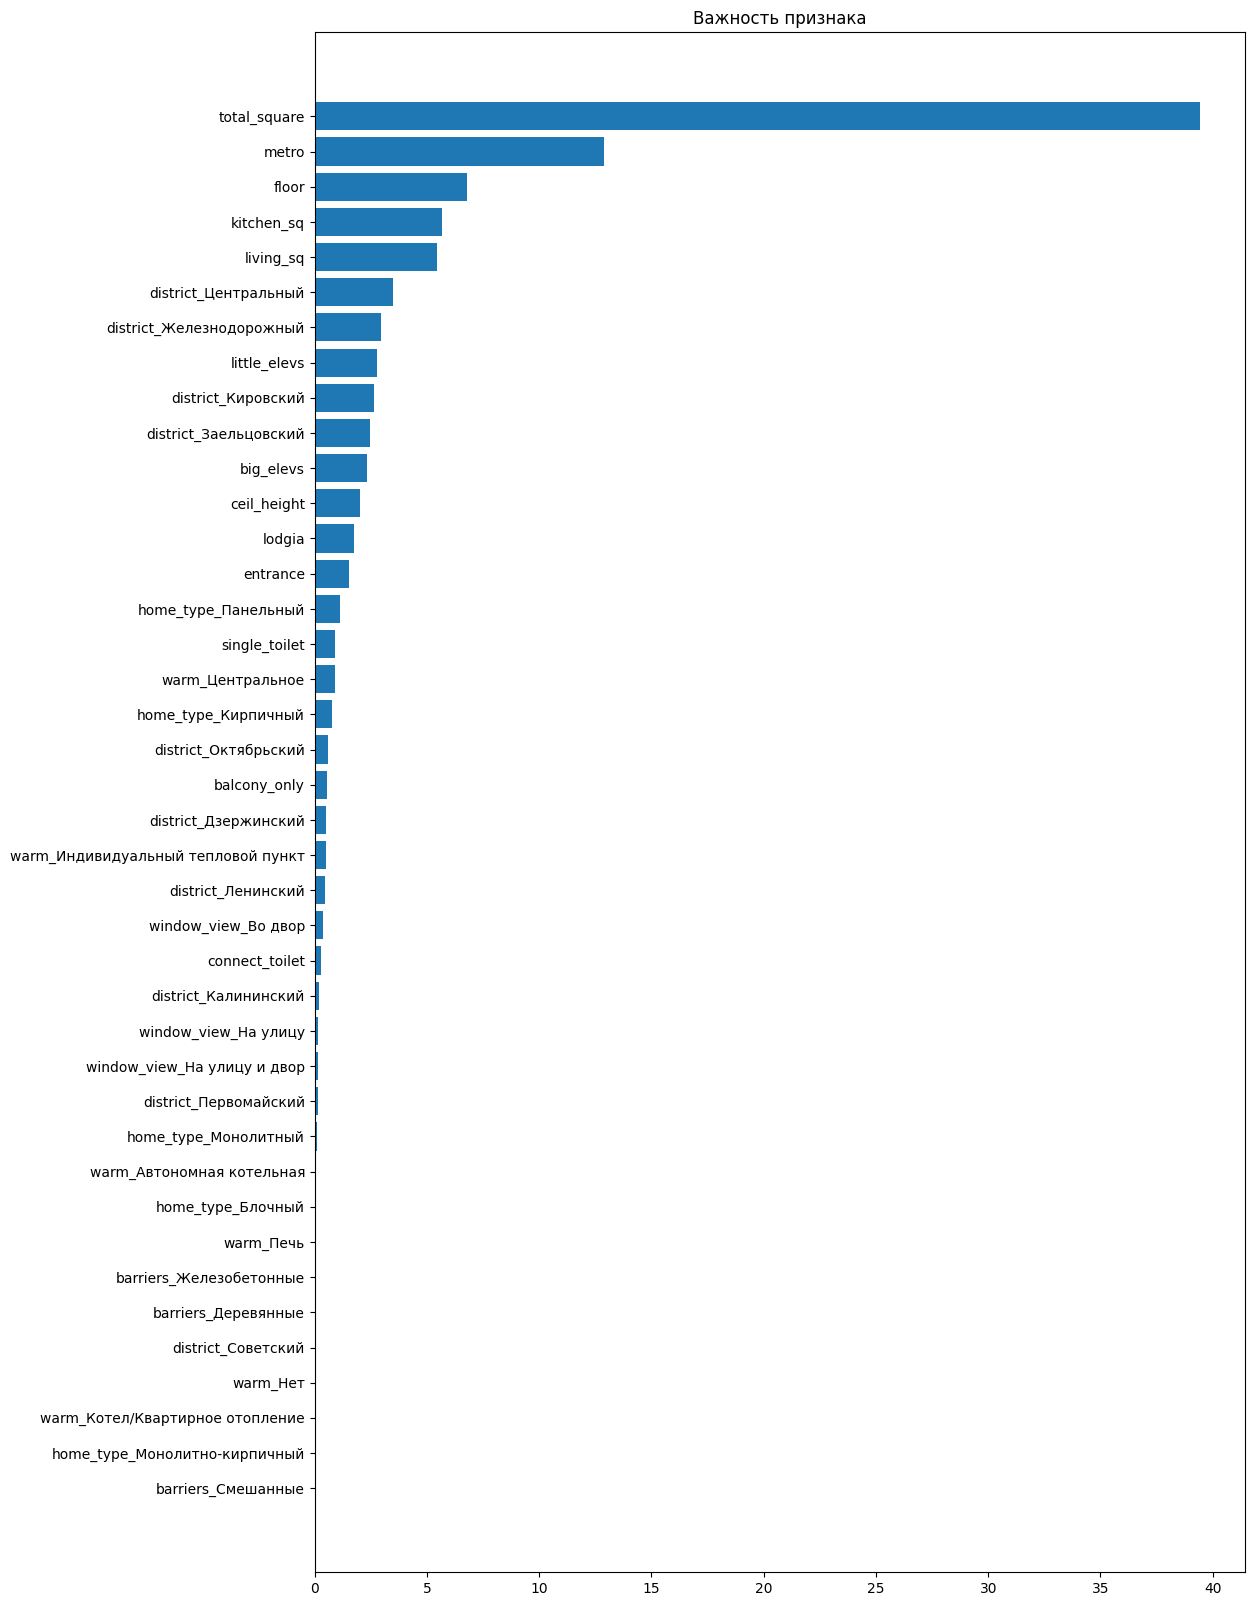

In [34]:
feature_importance = model_gb.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 20))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(test.drop('price', axis=1).columns)[sorted_idx])
plt.title('Важность признака')

Провалидируем модели в разрезе различных ценовых категорий. Помимо линейной регрессии, случайного леса и градиентного бустинга посмотрим на модель гребневой регрессии и лассо регрессии.

In [42]:

groups = [(1000000, 2000000), (2000000, 3000000), (3000000, 4000000), (4000000, 5000000), (5000000, 6000000), (6000000, 7000000), (7000000, float('inf'))]

print('Случайный лес: ')

for group in groups:
    print(f'{group[0]} рублей - {group[1]} рублей')
    predict = model_rf.predict(test[test['price'].between(group[0], group[1])].drop('price', axis=1))
    print(f'MAE: {mean_absolute_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print(f'MAPE: {mean_absolute_percentage_error(test[test["price"].between(group[0], group[1])]["price"], predict) * 100} %')
    print(f'MSE: {mean_squared_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print()


Случайный лес: 
1000000 рублей - 2000000 рублей
MAE: 1063459.7372133913
MAPE: 60.36486545495765 %
MSE: 1376801805035.5002

2000000 рублей - 3000000 рублей
MAE: 450407.40873863525
MAPE: 17.433183587622775 %
MSE: 450335670824.7701

3000000 рублей - 4000000 рублей
MAE: 344217.63978527376
MAPE: 10.24008908410189 %
MSE: 225130422263.25797

4000000 рублей - 5000000 рублей
MAE: 568277.6823329126
MAPE: 12.640410189246548 %
MSE: 584404525613.5975

5000000 рублей - 6000000 рублей
MAE: 673636.2749074452
MAPE: 12.305960868913537 %
MSE: 740770217560.5234

6000000 рублей - 7000000 рублей
MAE: 719419.1894609643
MAPE: 11.030703987423566 %
MSE: 849199308158.4734

7000000 рублей - inf рублей
MAE: 1707018.1932512189
MAPE: 17.533930525968554 %
MSE: 6308374784018.227



In [36]:
print('Градиентный бустинг: ')

for group in groups:
    print(f'{group[0]} рублей - {group[1]} рублей')
    predict = model_gb.predict(test[test['price'].between(group[0], group[1])].drop('price', axis=1))
    print(f'MAE: {mean_absolute_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print(f'MAPE: {mean_absolute_percentage_error(test[test["price"].between(group[0], group[1])]["price"], predict) * 100} %')
    print(f'MSE: {mean_squared_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print()

Градиентный бустинг: 
1000000 рублей - 2000000 рублей
MAE: 735574.3145442012
MAPE: 41.56831052334378 %
MSE: 818274262094.0635

2000000 рублей - 3000000 рублей
MAE: 364493.83206940664
MAPE: 14.062337827393645 %
MSE: 467400454782.76746

3000000 рублей - 4000000 рублей
MAE: 395119.72780840157
MAPE: 11.79050187091579 %
MSE: 281495326341.0174

4000000 рублей - 5000000 рублей
MAE: 578341.8517697607
MAPE: 12.930934194919233 %
MSE: 645697648974.2762

5000000 рублей - 6000000 рублей
MAE: 697495.814682581
MAPE: 12.735089316233243 %
MSE: 906317353219.481

6000000 рублей - 7000000 рублей
MAE: 812431.1265375995
MAPE: 12.4754130643229 %
MSE: 1212807053528.3472

7000000 рублей - inf рублей
MAE: 1400556.2864269551
MAPE: 14.66781117165886 %
MSE: 4501990509991.8955



In [39]:
print('Линейная регрессия: ')
model = LinearRegression()
model.fit(train_lr.drop('price', axis=1), train_lr['price'])

for group in groups:
    predict = model.predict(test_lr[test_lr['price'].between(group[0], group[1])].drop('price', axis=1))
    
    print(f'{group[0]} рублей - {group[1]} рублей')
    print(f'MAE: {mean_absolute_error(test_lr[test_lr["price"].between(group[0], group[1])]["price"], predict)}')
    print(f'MAPE: {mean_absolute_percentage_error(test_lr[test_lr["price"].between(group[0], group[1])]["price"], predict) * 100} %')
    print(f'MSE: {mean_squared_error(test_lr[test_lr["price"].between(group[0], group[1])]["price"], predict)}')
    print()

Линейная регрессия: 
1000000 рублей - 2000000 рублей
MAE: 1323774.5523506256
MAPE: 75.54804543439657 %
MSE: 5116841196494.0

2000000 рублей - 3000000 рублей
MAE: 515952.9299826278
MAPE: 19.703630034253646 %
MSE: 436394419690.7811

3000000 рублей - 4000000 рублей
MAE: 594422.1232689552
MAPE: 17.707984302191758 %
MSE: 564487792053.5557

4000000 рублей - 5000000 рублей
MAE: 692557.9814362655
MAPE: 15.697122274664977 %
MSE: 681036685788.2247

5000000 рублей - 6000000 рублей
MAE: 806253.4521275917
MAPE: 14.637849989010135 %
MSE: 992194993075.1858

6000000 рублей - 7000000 рублей
MAE: 828109.5405386242
MAPE: 12.609959480025426 %
MSE: 1031448638109.7645

7000000 рублей - inf рублей
MAE: 1252216.6677338772
MAPE: 13.50040902255842 %
MSE: 2870293166629.2017



In [40]:
print('Гребневая регрессия: ')

model = Ridge(random_state=42)
model.fit(train_lr.drop('price', axis=1), train_lr['price'])

for group in groups:
    predict = model.predict(test_lr[test_lr['price'].between(group[0], group[1])].drop('price', axis=1))
    
    print(f'{group[0]} рублей - {group[1]} рублей')
    print(f'MAE: {mean_absolute_error(test_lr[test_lr["price"].between(group[0], group[1])]["price"], predict)}')
    print(f'MAPE: {mean_absolute_percentage_error(test_lr[test_lr["price"].between(group[0], group[1])]["price"], predict) * 100} %')
    print(f'MSE: {mean_squared_error(test_lr[test_lr["price"].between(group[0], group[1])]["price"], predict)}')
    print()


Гребневая регрессия: 
1000000 рублей - 2000000 рублей
MAE: 1377797.0700593565
MAPE: 78.661144810233 %
MSE: 5149097284844.328

2000000 рублей - 3000000 рублей
MAE: 510629.55067782826
MAPE: 19.4844300974842 %
MSE: 424111420769.687

3000000 рублей - 4000000 рублей
MAE: 594104.2482341897
MAPE: 17.705270144194 %
MSE: 563417085447.5526

4000000 рублей - 5000000 рублей
MAE: 688823.0487474358
MAPE: 15.622581236664345 %
MSE: 679630051830.721

5000000 рублей - 6000000 рублей
MAE: 799888.5810614445
MAPE: 14.510464217367675 %
MSE: 970083682643.0411

6000000 рублей - 7000000 рублей
MAE: 813604.374427599
MAPE: 12.397278738437734 %
MSE: 1002366392459.8164

7000000 рублей - inf рублей
MAE: 1242762.1156927685
MAPE: 13.347662087222234 %
MSE: 2838123979215.6826



In [41]:
print('Лассо регрессия: ')

model = Lasso(random_state=42)
model.fit(train_lr.drop('price', axis=1), train_lr['price'])

for group in groups:
    predict = model.predict(test_lr[test_lr['price'].between(group[0], group[1])].drop('price', axis=1))
    
    print(f'{group[0]} рублей - {group[1]} рублей')
    print(f'MAE: {mean_absolute_error(test_lr[test_lr["price"].between(group[0], group[1])]["price"], predict)}')
    print(f'MAPE: {mean_absolute_percentage_error(test_lr[test_lr["price"].between(group[0], group[1])]["price"], predict) * 100} %')
    print(f'MSE: {mean_squared_error(test_lr[test_lr["price"].between(group[0], group[1])]["price"], predict)}')
    print()


Лассо регрессия: 
1000000 рублей - 2000000 рублей
MAE: 1323784.213452895
MAPE: 75.54773313258418 %
MSE: 5116871908843.448

2000000 рублей - 3000000 рублей
MAE: 515939.11310784414
MAPE: 19.70308694618096 %
MSE: 436355915588.5487

3000000 рублей - 4000000 рублей
MAE: 594415.7447500215
MAPE: 17.70778664334492 %
MSE: 564477284740.7908

4000000 рублей - 5000000 рублей
MAE: 692546.5605985632
MAPE: 15.69688230599959 %
MSE: 681017885487.1345

5000000 рублей - 6000000 рублей
MAE: 806235.4472925704
MAPE: 14.637513881982967 %
MSE: 992159442961.3597

6000000 рублей - 7000000 рублей
MAE: 828096.584048616
MAPE: 12.609761490248847 %
MSE: 1031418107131.2289

7000000 рублей - inf рублей
MAE: 1252211.6875851036
MAPE: 13.500344677130688 %
MSE: 2870275682313.5854



Можем видеть, что все модели плохо предсказывают цену "дешевых" квартир. В диапазоне от 3 миллионов до 5 миллионов лучше всех себя показывает градиентный бустинг, а цену "дорогих" квартир все модели предсказывают не очень хорошо, но значения ошибок не сильно различаются у моделей. Можно сделать вывод, что необходимо дополнить выборку квартирами с низкой ценой и высокой ценой, чтобы улучшить метрики качества моделей.